# Finding Similar Songs on Spotify - Part 2: Siamese Networks

In the first part of this tutorial I have introduced the traditional distance based approach to similarity estimations. The main idea is that features are extracted from the audio content. These features are numeric descriptions of semantically relevant information. An example for a high-level feature is the number of beats per minute which is a description for the tempo of a song. Music feature-sets are more abstract and describe the spectral or rhythmical distribution of energy. These are not single but vectors of numbers. Thus, a song is semantically described by this vector and if the set of extracted features spans over various music characteristics such as rhythm, timbre, harmonics, complexity, etc. then calculating the similarity of the vector's numbers is considered to be an approximation of music similarity. Thus, the lower the numerical distance between two vectors, the higher their acoustic similarity. For this reason these approaches are known as *Distance based* methods. They mainly depend on the selected sets of features and on the similarity metric chosen to compare their values.

In the second part of this tutorial we are now focussing on an approach, where the feature representation, as well as the similarity function is learned from the underlying dataset.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

The requirements are the same as for the first part of the tutorials. Please follow the instructions of part one if you have trouble running this tutorial.

In [2]:
%load_ext autoreload

%autoreload 2

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

# spotify API
import spotipy
import spotipy.util as util

# local caching
from joblib import Memory

# functions from Tutorial Part 1
import tutorial_functions as tut_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

Update the following two variables according the credentials you received from Spotify

In [3]:
os.environ["SPOTIPY_CLIENT_ID"]     = "8a7fffc37b6c44e6b7bc344c3295034c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "f19dd914ba58408c9407dd6479b23812"

The same playlists as used in Part 1:

In [4]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

Connect to the Spotify API

In [89]:
token = util.prompt_for_user_token("slychief", 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

Define the local chache directory. This should be the same as in Part 1 of the tutorial.

In [6]:
memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

Unfortunately I was not able to move this function to the tutorial_functions.py file, due to the @memory annotation. (If you know a way how to solve this, please create a Github-issue with your solution).

In [7]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

Start loading the Spotify Data

In [8]:
# Get Playlist meta-data
playlists = tut_func.get_playlist_metadata(sp, playlists)

# Get track-ids of all playlist entries
playlists = tut_func.get_track_ids(sp, playlists)

num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])

# Fetch data and features from Spotify
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:

    for track_id in playlist["track_ids"]:

        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:

                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)

                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)

        except Exception as e:
            print e

        pbar.update(len(raw_track_data))

 97% (963 of 987) |#################################################################################################################################################################################     | Elapsed Time: 0:00:41 ETA: 0:00:01

# Siamese Networks

A Siamese neural network is a neural network architecture where two inputs are fed into the same stack of network layers. This is where the name comes from. The shared layers are "similar" to Siamese Twins. By feeding two inputs to the shared layers, two representations are generated which can be used for comparison. To train the network according a certain task, it requires labelled data. To learn a simlarity function, these labels should indicate if the two input are similar or dissimilar.

This is exactly the approach initially described by [TODO cite paper]
The authors create pairs of simlar and dissimilar images. These are fed into a Siamese NEtwork stack. Finally, the model calculates the eucledian distance between the two generated representations. A contrastive loss is used, to optimize the learned simlarity.

To calculate the similarity between a seed image and the rest of the collection, the model is applied to predict the distance between this seed image and every other. The result is a list of distances which has to be sorted descendingly.

The following code example follows this approach:

**Keras**

We use the high-level deep learning API Keras. [TODO: link]

[TODO: describe - auf Tom's Tutorial verweisen für instructoins]

In [9]:
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.optimizers import Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
from keras.layers.merge import concatenate

First we define a distance measure to compare the two representations. We will be using the well known Eucledian distance:

In [10]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

Now we define the Siamese Network Architecture. It consists of three fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Eucledian distance of the output of each twin is calculated which is the final output of the model.

In [11]:
def create_siamese_network(input_dim):

    dense_1 = Dense(100, activation="selu")
    dense_2 = Dense(100, activation="selu")
    dense_3 = Dense(100, activation="selu")

    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)
    
    layers_left  = dense_1(dense_2(dense_3(input_left)))
    layers_right = dense_1(dense_2(dense_3(input_right)))

    distance = Lambda(euclidean_distance,
                      output_shape=lambda x: x[0])([layers_left, layers_right])

    model = Model([input_left, input_right], distance)
    
    return model

In [12]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Aggregate feature-data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

In [13]:
# Aggregate Meta-data
metadata = tut_func.aggregate_metadata(raw_track_data)

# Aggregate Feature-data
feature_data = tut_func.aggregate_featuredata(raw_track_data, metadata)

# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

### Create Data-Pairs

In [14]:
def create_pairs(feature_data, metadata, num_pairs_per_track):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(1)

            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(0)

    return np.array(data_pairs), np.array(labels)

In [15]:
data_pairs, labels = create_pairs(feature_data, metadata, 10)

data_pairs.shape

(19260, 2, 69)

In [34]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

# train
rms = Nadam(lr=0.001)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=["mean_squared_error", "accuracy"])

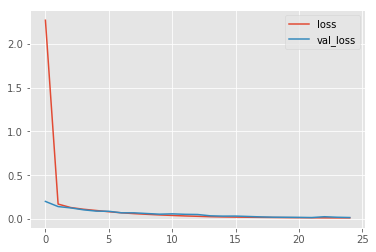

In [35]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], 
          labels, 
          batch_size       = 6, 
          verbose          = 0, 
          epochs           = 25, 
          callbacks        = [tut_func.PlotLosses()], 
          validation_split = 0.1)

In [111]:
result

NameError: name 'result' is not defined

In [149]:
def similar(query_idx, ascending=False):
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    res = np.array(res)
    res = res.reshape(res.shape[0])

    if ascending:
        si = np.argsort(res)[::-1]
    else:
        si = np.argsort(res)
    
    print metadata.iloc[query_idx]

    sp.user_playlist_replace_tracks("slychief", "0FSLWht5SiNQMVPt3tBOIR", metadata.loc[si, "track_id"][:10])
    
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

In [151]:
similar(627)

track_id       0BAjUM6V9P9g8rK83hVUTJ                                                                            
artist_name    Metallica                                                                                         
title          The Unforgiven                                                                                    
album_name     Metallica                                                                                         
label          Digital Distribution Trinidad and Tobago                                                          
duration       386493                                                                                            
popularity     71                                                                                                
year           1991                                                                                              
genres         [alternative metal, alternative rock, hard rock, metal, nu metal, rock, s

,artist_name,title,album_name,year,playlist
627,Metallica,The Unforgiven,Metallica,1991,metal
658,Testament,Brotherhood of the Snake,Brotherhood of the Snake,2016,metal
676,Deftones,My Own Summer (Shove It),Around The Fur,1997,metal
691,Amon Amarth,Twilight Of The Thunder God,Twilight Of The Thunder God,2008,metal
693,Volbeat,Lola Montez,Outlaw Gentlemen & Shady Ladies (Deluxe Version),2013,metal
650,Trivium,Strife,Vengeance Falls (Special Edition),2013,metal
624,Linkin Park,One Step Closer,Hybrid Theory (Bonus Track Version),2000,metal
636,Volbeat,Still Counting,Guitar Gangsters & Cadillac Blood,2008,metal
697,P.O.D.,Alive - New Album/Chris Lord-Alge Mix Version,Satellite (U.S. Version WEA Distribution),2001,metal
686,Avenged Sevenfold,Bat Country,City Of Evil (PA Version),2005,metal


In [153]:
from IPython.display import IFrame

In [155]:
IFrame("https://open.spotify.com/embed?uri=spotify:user:slychief:playlist:0FSLWht5SiNQMVPt3tBOIR", 300,400)

In [152]:
HTML('<iframe src="https://open.spotify.com/embed?uri=spotify:user:slychief:playlist:0FSLWht5SiNQMVPt3tBOIR" width="300" height="380" frameborder="0" allowtransparency="true"></iframe>')

In [53]:
sp.user_playlist_create("slychief", "tutorial_2", public=True)

{u'collaborative': False,
 u'description': None,
 u'external_urls': {u'spotify': u'http://open.spotify.com/user/slychief/playlist/0FSLWht5SiNQMVPt3tBOIR'},
 u'followers': {u'href': None, u'total': 0},
 u'href': u'https://api.spotify.com/v1/users/slychief/playlists/0FSLWht5SiNQMVPt3tBOIR',
 u'id': u'0FSLWht5SiNQMVPt3tBOIR',
 u'images': [],
 u'name': u'tutorial_2',
 u'owner': {u'external_urls': {u'spotify': u'http://open.spotify.com/user/slychief'},
  u'href': u'https://api.spotify.com/v1/users/slychief',
  u'id': u'slychief',
  u'type': u'user',
  u'uri': u'spotify:user:slychief'},
 u'public': True,
 u'snapshot_id': u'NQLBOFDywWUF30IRiO/Z+xBKnO2SSgvrKhxwWJ5fey+ciSeNJKa9bnEwj7ORmwR4',
 u'tracks': {u'href': u'https://api.spotify.com/v1/users/slychief/playlists/0FSLWht5SiNQMVPt3tBOIR/tracks',
  u'items': [],
  u'limit': 100,
  u'next': None,
  u'offset': 0,
  u'previous': None,
  u'total': 0},
 u'type': u'playlist',
 u'uri': u'spotify:user:slychief:playlist:0FSLWht5SiNQMVPt3tBOIR'}

In [63]:
sp.user_playlist("slychief", "0FSLWht5SiNQMVPt3tBOIR")

{u'collaborative': False,
 u'description': None,
 u'external_urls': {u'spotify': u'http://open.spotify.com/user/slychief/playlist/0FSLWht5SiNQMVPt3tBOIR'},
 u'followers': {u'href': None, u'total': 0},
 u'href': u'https://api.spotify.com/v1/users/slychief/playlists/0FSLWht5SiNQMVPt3tBOIR',
 u'id': u'0FSLWht5SiNQMVPt3tBOIR',
 u'images': [],
 u'name': u'tutorial_2',
 u'owner': {u'external_urls': {u'spotify': u'http://open.spotify.com/user/slychief'},
  u'href': u'https://api.spotify.com/v1/users/slychief',
  u'id': u'slychief',
  u'type': u'user',
  u'uri': u'spotify:user:slychief'},
 u'public': True,
 u'snapshot_id': u'NQLBOFDywWUF30IRiO/Z+xBKnO2SSgvrKhxwWJ5fey+ciSeNJKa9bnEwj7ORmwR4',
 u'tracks': {u'href': u'https://api.spotify.com/v1/users/slychief/playlists/0FSLWht5SiNQMVPt3tBOIR/tracks?offset=0&limit=100',
  u'items': [],
  u'limit': 100,
  u'next': None,
  u'offset': 0,
  u'previous': None,
  u'total': 0},
 u'type': u'playlist',
 u'uri': u'spotify:user:slychief:playlist:0FSLWht5SiNQM

In [ ]:
similar(753, ascending=True)

In [ ]:
def create_siamese_network(input_dim, loss="mean_squared_error"):

    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)

    dense_1 = Dense(100, activation="selu")
    dense_2 = Dense(100, activation="selu")
    dense_3 = Dense(100, activation="selu")
    
    #network = dense_1(dense_2(dense_3))
    
    layers_left  = dense_1(dense_2(dense_3(input_left)))
    layers_right = dense_1(dense_2(dense_3(input_right)))

    L1_distance = lambda x: K.abs(x[0]-x[1])

    distance = Lambda(L1_distance,
                      output_shape=lambda x: x[0])([layers_left, layers_right])

    prediction = Dense(100, activation="elu")(distance)

    prediction = Dense(1, activation="sigmoid")(prediction)

    model = Model([input_left, input_right], prediction)

    # train
    rms = Nadam(lr=0.001)
    model.compile(loss=loss, optimizer=rms, metrics=["mean_squared_error", "accuracy"])
    
    return model

In [ ]:
similar(753, ascending=True)

In [ ]:
similar(470, ascending=True)

# Evaluate

In [ ]:
def evaluate(similarity_function, cut_off):

    global dist
    
    all_precisions = []

    for idx in metadata.index.values:

        dist           = similarity_function(feature_data, feature_data[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
playlist_names = [pl["name"] for pl in playlists]

playlist_similarities = pd.DataFrame(np.zeros((len(playlist_names),len(playlist_names))), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

In [ ]:
sim = [[["clubbeats",    "electropop"],    0.8],
       [["clubbeats",    "softpop"],      0.4],
       [["electropop",   "hiphop"],      0.4],
       [["softpop",      "soft_rock"],      0.2],
       [["softpop",      "electropop"],      0.4],
       [["softpop",    "hiphop"],      0.1],
       [["rockclassics",    "rockhymns"],      0.7],
       [["soft_rock",    "rockclassics"],      0.3],
       [["soft_rock",    "rockhymns"],      0.3],
       [["metalcore",    "metal"],      0.7],
       [["metalcore",    "classic_metal"],      0.6],
       [["metal",    "classic_metal"],      0.8],
       [["classic_metal",    "grunge"],      0.5],
       [["metal",    "grunge"],      0.5],
       [["rockhymns",    "grunge"],      0.2],
       [["poppunk",    "metal"],      0.6],
       [["poppunk",    "classic_metal"],      0.4],
       [["poppunk",    "rockhymns"],      0.5],
       [["poppunk",    "rockclassics"],      0.4]
     ]

# self-similarity
for i in range(len(playlist_names)):
    for j in range(len(playlist_names)):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

for s in sim:
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

playlist_similarities

In [ ]:
def create_pairs_with_sims(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist])

            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist])

    return np.array(data_pairs), np.array(labels)

In [ ]:
data_pairs, labels = create_pairs_with_sims(feature_data, metadata, 10, playlist_similarities)

In [ ]:
data_pairs.shape

In [ ]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

In [ ]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], labels, batch_size=24, verbose=1, epochs=25)

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
def create_pairs_with_sims_and_identity(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        data_pairs.append([feature_data[[row_id]][0], feature_data[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1)

            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1)

    return np.array(data_pairs), np.array(labels)

In [ ]:
data_pairs, labels = create_pairs_with_sims_and_identity(feature_data, metadata, 10, playlist_similarities)

In [ ]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

In [ ]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], labels, batch_size=24, verbose=1, epochs=25)

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
def aggregate_features_sequential(seq_data, track_data, len_segment, m_data, with_year=False, with_popularity=False):
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    mfcc              = np.array([s["timbre"]            for s in segments])
    chroma            = np.array([s["pitches"]           for s in segments])
    loudness_max      = np.array([s["loudness_max"]      for s in segments]).reshape((sl,1))
    loudness_start    = np.array([s["loudness_start"]    for s in segments]).reshape((sl,1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    duration          = np.array([s["duration"]          for s in segments]).reshape((sl,1))
    confidence        = np.array([s["confidence"]        for s in segments]).reshape((sl,1))
    
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=1)
    
    offset  = np.random.randint(0, sl - len_segment)
    segment = sequential_features[offset:(offset+len_segment),:]
        
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(m_data["year"]))
        
    if with_popularity:
        track_features.append(int(m_data["popularity"]))
        
    
    return segment, track_features


In [ ]:
len_segment = 20

sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = aggregate_features_sequential(f_sequential, 
                                                         f_trackbased, 
                                                         len_segment, 
                                                         metadata.loc[i],
                                                         with_year=True,
                                                         with_popularity=True)
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print "sequential_features.shape:", sequential_features.shape
print "trackbased_features.shape:", trackbased_features.shape

In [ ]:
# standardize sequential_features
rows, x, y = sequential_features.shape
sequential_features = sequential_features.reshape(rows, (x * y))
sequential_features -= sequential_features.mean(axis=0)
sequential_features /= sequential_features.std(axis=0)
sequential_features = sequential_features.reshape(rows, x, y)

In [ ]:
# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

In [ ]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[row_id]][0]])
        data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[pos_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1)

            data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[neg_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1)

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

In [ ]:
data_pairs_seq, data_pairs_track, labels = create_pairs_with_sims_and_identity_segments(sequential_features,
                                                                                        trackbased_features,
                                                                                        metadata, 
                                                                                        10, 
                                                                                        playlist_similarities)

In [ ]:
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Input, Lambda
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda,Convolution1D
from keras.optimizers import RMSprop, Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
#from keras.constraint import unit_norm
from keras.layers.merge import concatenate

In [ ]:
input_dim = data_pairs_seq[:, 0].shape[1:]

input_a = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_b = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_a2 = Input(shape=data_pairs_track[:, 0].shape[1:])
input_b2 = Input(shape=data_pairs_track[:, 0].shape[1:])

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(9, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance,
                  output_shape=lambda x: x[0])([left, right])

prediction = Dense(29 + 9, activation="elu")(distance)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [ ]:
model.fit([data_pairs_seq[:, 0], data_pairs_seq[:, 1], data_pairs_track[:,0], data_pairs_track[:,1]], labels, batch_size=24, verbose=1, epochs=25)

In [ ]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    
    pbar = progressbar.ProgressBar()

    for idx in pbar(metadata.index.values):

        dist           = similarity_function(sequential_features, sequential_features[[idx]], trackbased_features, trackbased_features[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[::-1][:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [ ]:
evaluate(lambda w,x,y,z: [model.predict([w[[i]],x,y[[i]],z]) for i in range(sequential_features.shape[0])], 20)